<a href="https://colab.research.google.com/github/danielsabino/ppgti3007_cv_2021_2/blob/semana04/semana04/aula07/%5Bnotebook%5Dcv_w04_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook adaptado de: https://curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/

# Object Detection on a Custom Dataset using YOLO v5

> Learn how to build a custom dataset for YOLO v5 (darknet compatible) and use it to fine-tune a large object detection model. 

In this tutorial, you'll learn how to fine-tune a pre-trained YOLO v5 model for detecting and classifying clothing items from images.

- [Read the tutorial](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1e4zvS6LyhOAayEDh3bz8MXFTJcVFSvZX?usp=sharing)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

Here's what we'll go over:

- Install required libraries
- Build a custom dataset in YOLO/darknet format
- Learn about YOLO model family history
- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions

How good our final model is going to be?



In [ ]:
# check whether there is GPU available
!nvidia-smi

Fri Mar  4 19:21:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Build a dataset

The dataset contains annotations for face mask detection. 

> The original dataset can be found at https://www.kaggle.com/andrewmvd/face-mask-detection. 

In [ ]:
# install package to download files from Google Drive
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=f5ed061193f1feca8b9add47df7cb71061a0e7265bfdf80757710802ee1eb767
  Stored in directory: /tmp/pip-ephem-wheel-cache-bwpp2877/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
# download the dataset
!gdown --id 1ThY-o-N7hMgJlkFralOdi0SIW2terqyG

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ThY-o-N7hMgJlkFralOdi0SIW2terqyG
To: /content/archive.zip
100% 417M/417M [00:06<00:00, 66.7MB/s]


The dataset contains a single zip file with. Lets unzip it.

In [ ]:
!unzip -q 'archive.zip'

Two folders were unzipped: `images` which has all the actual images of the dataset (people with and without mask), and `annotations` which has a `.xml` file for each image. The `xml` file stores information about the image, such as bouding box locations, size, class of each bouding box.

### Exploring the data

Let's import some required libraries and we'll add some others after.

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from bs4 import BeautifulSoup
from google.colab.patches import cv2_imshow
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

The dataset has images and XML annotations with data about class, bouding box position, among other stuff. For each image file, there is a XML annotation file.

In [ ]:
# define directory paths
images_dir = Path('images')
annotations_dir = Path('annotations')
# list all image and annotation files
image_files = sorted(list(images_dir.glob('*.png')))
annotation_files = sorted(list(annotations_dir.glob('*.xml')))

Here is an image sample.

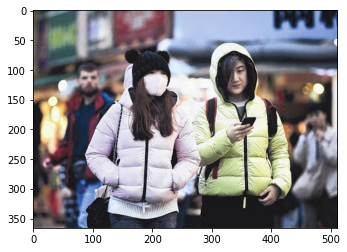

In [ ]:
# read sample image
image_file = image_files[0]
image = cv2.imread(str(image_file))
# convert BGR (opencv) to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Lets see how the annotation files are:

In [ ]:
annotation_file = annotation_files[0]
with open(annotation_file) as f:
  data = f.read()
  soup = BeautifulSoup(data, 'xml')
soup

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>images</folder>
<filename>maksssksksss0.png</filename>
<size>
<width>512</width>
<height>366</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>79</xmin>
<ymin>105</ymin>
<xmax>109</xmax>
<ymax>142</ymax>
</bndbox>
</object>
<object>
<name>with_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>185</xmin>
<ymin>100</ymin>
<xmax>226</xmax>
<ymax>144</ymax>
</bndbox>
</object>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>325</xmin>
<ymin>90</ymin>
<xmax>360</xmax>
<ymax>141</ymax>
</bndbox>
</object>
</annotation>

Among all data, we are interested mainly in the class, bounding box position, width and height. Let's annotate one image to check these information.

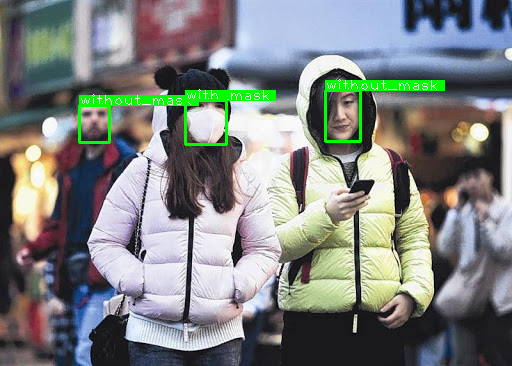

In [ ]:
image_file = image_files[0]
image = cv2.imread(str(image_file))

# read and show bouding boxes
annotation_file = annotation_files[0]
with open(annotation_file) as f:
  data = f.read()
  soup = BeautifulSoup(data, 'xml')
  objects = soup.find_all('object')
  for obj in objects:
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    label = str(obj.find('name').text)

    ((label_width, label_height), _) = cv2.getTextSize(
      label, 
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1, 
      thickness=1
    )

    cv2.rectangle(
      image,
      (int(xmin), int(ymin-label_height)),
      (int(xmin + label_width + label_width * 0.05), int((ymin-label_height) + label_height + label_height*0.05)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      image,
      label,
      org=(int(xmin), int(ymin)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1,
      color=(255, 255, 255),
      thickness=1
    )
    cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,255,0),2)
cv2_imshow(image)

### Filtering the data
We have the labels, image dimensions, bounding box points. In fact, the dataset contains originally three classes.

In [ ]:
classes = ['without_mask', 'with_mask', 'mask_weared_incorrect']

However, the `mask_weared_incorrect` just few examples. So, to the contexto of this project, we will remove all images containing the `mask_weares_incorrect` annotation.

In [ ]:
def filter_dataset(image_files,annotation_files):

  # define new folder for the filtered dataset and annotations
  filtered_images_path = Path(f'images_filtered/')
  filtered_images_path.mkdir(parents=True, exist_ok=True)

  filtered_annotations_path = Path(f'annotations_filtered/')
  filtered_annotations_path.mkdir(parents=True, exist_ok=True)

  # for each annotation file
  for (image_file,annotation_file) in tqdm(zip(image_files,annotation_files),total=len(image_files)):
    # read file  
    with open(annotation_file) as f:
      data = f.read()
      soup = BeautifulSoup(data, 'xml')
      objects = soup.find_all('object')      
      names = [obj.find('name').text for obj in objects ]
      if 'mask_weared_incorrect' in names:
        continue

    # copy image file to respective directory
    shutil.copy(image_file, filtered_images_path)
    shutil.copy(annotation_file, filtered_annotations_path)   
    

In [ ]:
filter_dataset(image_files, annotation_files)

100%|██████████| 853/853 [00:03<00:00, 243.97it/s]


Now our classes are:

In [ ]:
classes = ['without_mask', 'with_mask']

In [ ]:
# update directory paths
images_dir = Path('images_filtered')
annotations_dir = Path('annotations_filtered')
# list all image and annotation files
image_files = sorted(list(images_dir.glob('*.png')))
annotation_files = sorted(list(annotations_dir.glob('*.xml')))

In order to train our model, lets split the data into training and validation.

In [ ]:
image_train_files, image_val_files, annotation_train_files, annotation_val_files = train_test_split(image_files, annotation_files, test_size=0.10, random_state=42)

After the filtering process, this is the size of our dataset:

In [ ]:
len(image_train_files), len(image_val_files)

(680, 76)

### Convert to YOLO format

YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1

Let's create a helper function that builds a dataset in the correct format for us. This function creates two folders for each bunch of data (train ou validation) passed to it: images and labels. In the first, the images are copied from the original folder to this new folder. The last reads the annotation file, convert the required data for the YOLO format and save a new `.txt` file with these data.

In [ ]:
def create_dataset(image_files,annotation_files,dataset_type):

  # create new folders for image and label files
  images_path = Path(f'mask_dataset/images/{dataset_type}')
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f'mask_dataset/labels/{dataset_type}')
  labels_path.mkdir(parents=True, exist_ok=True)

  # for each annotation file
  for (image_file,annotation_file) in tqdm(zip(image_files,annotation_files),total=len(image_files)):
    # copy image file to respective directory
    shutil.copy(image_file, images_path)
    # create .txt with YOLO format annotations
    # open XML file
    file_name = str(annotation_file).split('/')[-1].split('.')[0]
    f_label = open(f'{str(labels_path)}/{file_name}.txt', 'w+')
    with open(annotation_file) as f:
      data = f.read()
      soup = BeautifulSoup(data, 'xml')
      objects = soup.find_all('object')

      # get width and height of the image
      width = int(soup.find('size').find('width').text)
      height = int(soup.find('size').find('height').text)

      # for all subjects in the image
      for obj in objects:
        # get bb information and normalize it
        xmin = float(obj.find('xmin').text)/width
        ymin = float(obj.find('ymin').text)/height
        xmax = float(obj.find('xmax').text)/width
        ymax = float(obj.find('ymax').text)/height
        # get bbox width and height
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin        
        # get class
        label = str(obj.find('name').text)
        # get class as number
        class_idx = classes.index(label)
        # write all data in txt file        
        f_label.write(f'{class_idx} {xmin + bbox_width / 2} {ymin + bbox_height / 2} {bbox_width} {bbox_height}\n')
    f_label.close()


In [ ]:
# creating train and validation datasets
create_dataset(image_train_files,annotation_train_files, 'train')
create_dataset(image_val_files,annotation_val_files, 'val')

100%|██████████| 76/76 [00:00<00:00, 202.55it/s]


You can see the new folder `mask_dataset` and inside we have folders to image and labels for the training and validation datasets.

In [ ]:
# install package to visualizae directory tree
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (58.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Our dataset directory tree was created in the following configuration:

In [ ]:
!tree mask_dataset -L 2

mask_dataset
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


## Fine-tuning YOLO v5

The YOLO abbreviation stands for You Only Look Once. YOLO models are one stage object detectors. 

YOLO models are very light and fast. They are [not the most accurate object detections around](https://paperswithcode.com/sota/object-detection-on-coco), though. Ultimately, those models are the choice of many (if not all) practitioners interested in [real-time object detection (FPS >30)](https://paperswithcode.com/sota/real-time-object-detection-on-coco).

### Contreversy

Joseph Redmon introduced YOLO v1 in the 2016 paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf). The implementation uses the [Darknet Neural Networks library](https://pjreddie.com/darknet/).

He also co-authored the YOLO v2 paper in 2017  [YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf). A significant improvement over the first iteration with much better localization of objects.

The final iteration, from the original author, was published in the 2018 paper [YOLOv3: An Incremental Improvement](https://arxiv.org/pdf/1804.02767.pdf).

Then things got a bit wacky. Alexey Bochkovskiy published [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) on April 23, 2020. The project has [an open-source repository on GitHub](https://github.com/AlexeyAB/darknet).

YOLO v5 got open-sourced on [May 30, 2020](https://github.com/ultralytics/yolov5/commit/1e84a23f38fad9e52b59101e9f1246d93066ed1e) by [Glenn Jocher](https://github.com/glenn-jocher) from ultralytics. There is no published paper, but [the complete project is on GitHub](https://github.com/ultralytics/yolov5).

The community at Hacker News got into a [heated debate about the project naming](https://news.ycombinator.com/item?id=23478151). Even the guys at Roboflow wrote [Responding to the Controversy about YOLOv5](https://blog.roboflow.ai/yolov4-versus-yolov5/) article about it. They also did a great comparison between YOLO v4 and v5.

### YOLO v5 project setup

YOLO v5 uses PyTorch, but everything is abstracted away. You need the project itself (along with the required dependencies).

Let's start by cloning the GitHub repo, enter the directory and install the requirements.

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 11162, done.
remote: Total 11162 (delta 0), reused 0 (delta 0), pack-reused 11162
Receiving objects: 100% (11162/11162), 11.14 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (7711/7711), done.
/content/yolov5


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 596 kB 4.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


We need two configuration files. One for the dataset and one for the model we're going to use. Fot this project, we will use the `yolov5m`. Let's download them:

In [ ]:
!gdown --id 1qZm9ABNJdpLrmJKffg0_axc_2_XliX_C -O data/mask.yaml
!gdown --id 1Tq2rH0f7v2jKemLpyZwKm_HCQ_b9woa4 -O models/yolov5m.yaml

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qZm9ABNJdpLrmJKffg0_axc_2_XliX_C
To: /content/yolov5/data/mask.yaml
100% 115/115 [00:00<00:00, 182kB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Tq2rH0f7v2jKemLpyZwKm_HCQ_b9woa4
To: /content/yolov5/models/yolov5m.yaml
100% 1.41k/1.41k [00:00<00:00, 2.60MB/s]


In model config (yolov5m.yaml) we changed only the number of classes to 2 (equal to the ones in our dataset). The rest of the file, remains the same:

```yaml
# YOLOv5 ðŸš€ by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
```

The other file 'mask.yaml', there are the path for the train and validation datasets as well as the number and name of the classes.

```yaml
train: ../mask_dataset/images/train/
val: ../mask_dataset/images/val/

nc: 2

names: ['without_mask', 'with_mask']
```

### Training

Fine-tuning an existing model is very easy. We'll use an intermediate model **YOLOv5m** (21M parameters), which has maybe enough precision for our problem.

We want the best accuracy with sufficient speed. The checkpoint you're going to use for a different problem(s) is contextually specific. [Take a look at the overview of the pre-trained checkpoints](https://github.com/ultralytics/yolov5/blob/f9ae460eeccd30bdc43a89a37f74b9cc7b93d52f/README.md#pretrained-checkpoints).

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass a couple of parameters:

- img 640 - resize the images to 640x640 pixels
- batch -1 - let yolo define the best number of images per batch
- epochs 30 - train for 30 epochs
- data ./data/mask.yaml - path to dataset config
- cfg ./models/yolov5m.yaml - model config
- weights yolov5m.pt - use pre-trained weights from the YOLOv5m model
- name yolov5m_masking - name of our model
- cache - cache dataset images for faster training

The training for 30 epochs may take a while (~30 minutes using Colab's GPU).


In [ ]:
!python train.py \
  --img 640 \
  --batch -1 \
  --epochs 30 \
  --data ./data/mask.yaml \
  --cfg ./models/yolov5m.yaml \
  --weights yolov5m.pt \
  --name yolov5m_masking \
  --cache

train: weights=yolov5m.pt, cfg=./models/yolov5m.yaml, data=./data/mask.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5m_masking, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-14-g8a66eba torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

The best model checkpoint is saved to `weights/best_yolov5m_masking.pt`.

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

In [ ]:
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

from utils.plots import plot_results

plot_results('/content/yolov5/runs/train/yolov5m_masking/results.csv')

Looks like the mean average precision (mAP) is getting better throughout the training. The model might benefit from more training, but it is good enough.

> You should look at the files in the train/yolov5_masking files. There are some cools pictures there.

## Making predictions

Let's pick 50 images from the validation set and move them to `inference/images` to see how our model does on those (you can also include some images):

In [ ]:
inference_path = Path('./inference/images')
inference_path.mkdir(parents=True, exist_ok=True)

!find ../mask_dataset/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./inference/images/"

We'll use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights runs/train/yolov5m_mask/weights/best.pt - checkpoint of the model
- img 640 - resize the images to 640x640 px
- conf 0.4 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [ ]:
!python detect.py --weights runs/train/yolov5m_masking/weights/best.pt \
  --img 640 --conf 0.4 --source ./inference/images/

detect: weights=['runs/train/yolov5m_masking/weights/best.pt'], source=./inference/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-14-g8a66eba torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 290 layers, 20856975 parameters, 0 gradients, 48.0 GFLOPs
image 1/50 /content/yolov5/inference/images/maksssksksss128.png: 640x512 1 without_mask, Done. (0.073s)
image 2/50 /content/yolov5/inference/images/maksssksksss138.png: 448x640 3 with_masks, Done. (0.065s)
image 3/50 /content/yolov5/inference/images/maksssksksss165.png: 640x640 2 with_masks, Done. (0.077s)
image 4/50 /content/yolov5/inference/images/maksssksks

We'll write a helper function to show the results:

In [60]:
import torch, torchvision
import matplotlib.pyplot as plt

def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=5)
  plt.figure(figsize=(24, 24))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

Here are some of the images along with the detected clothing:

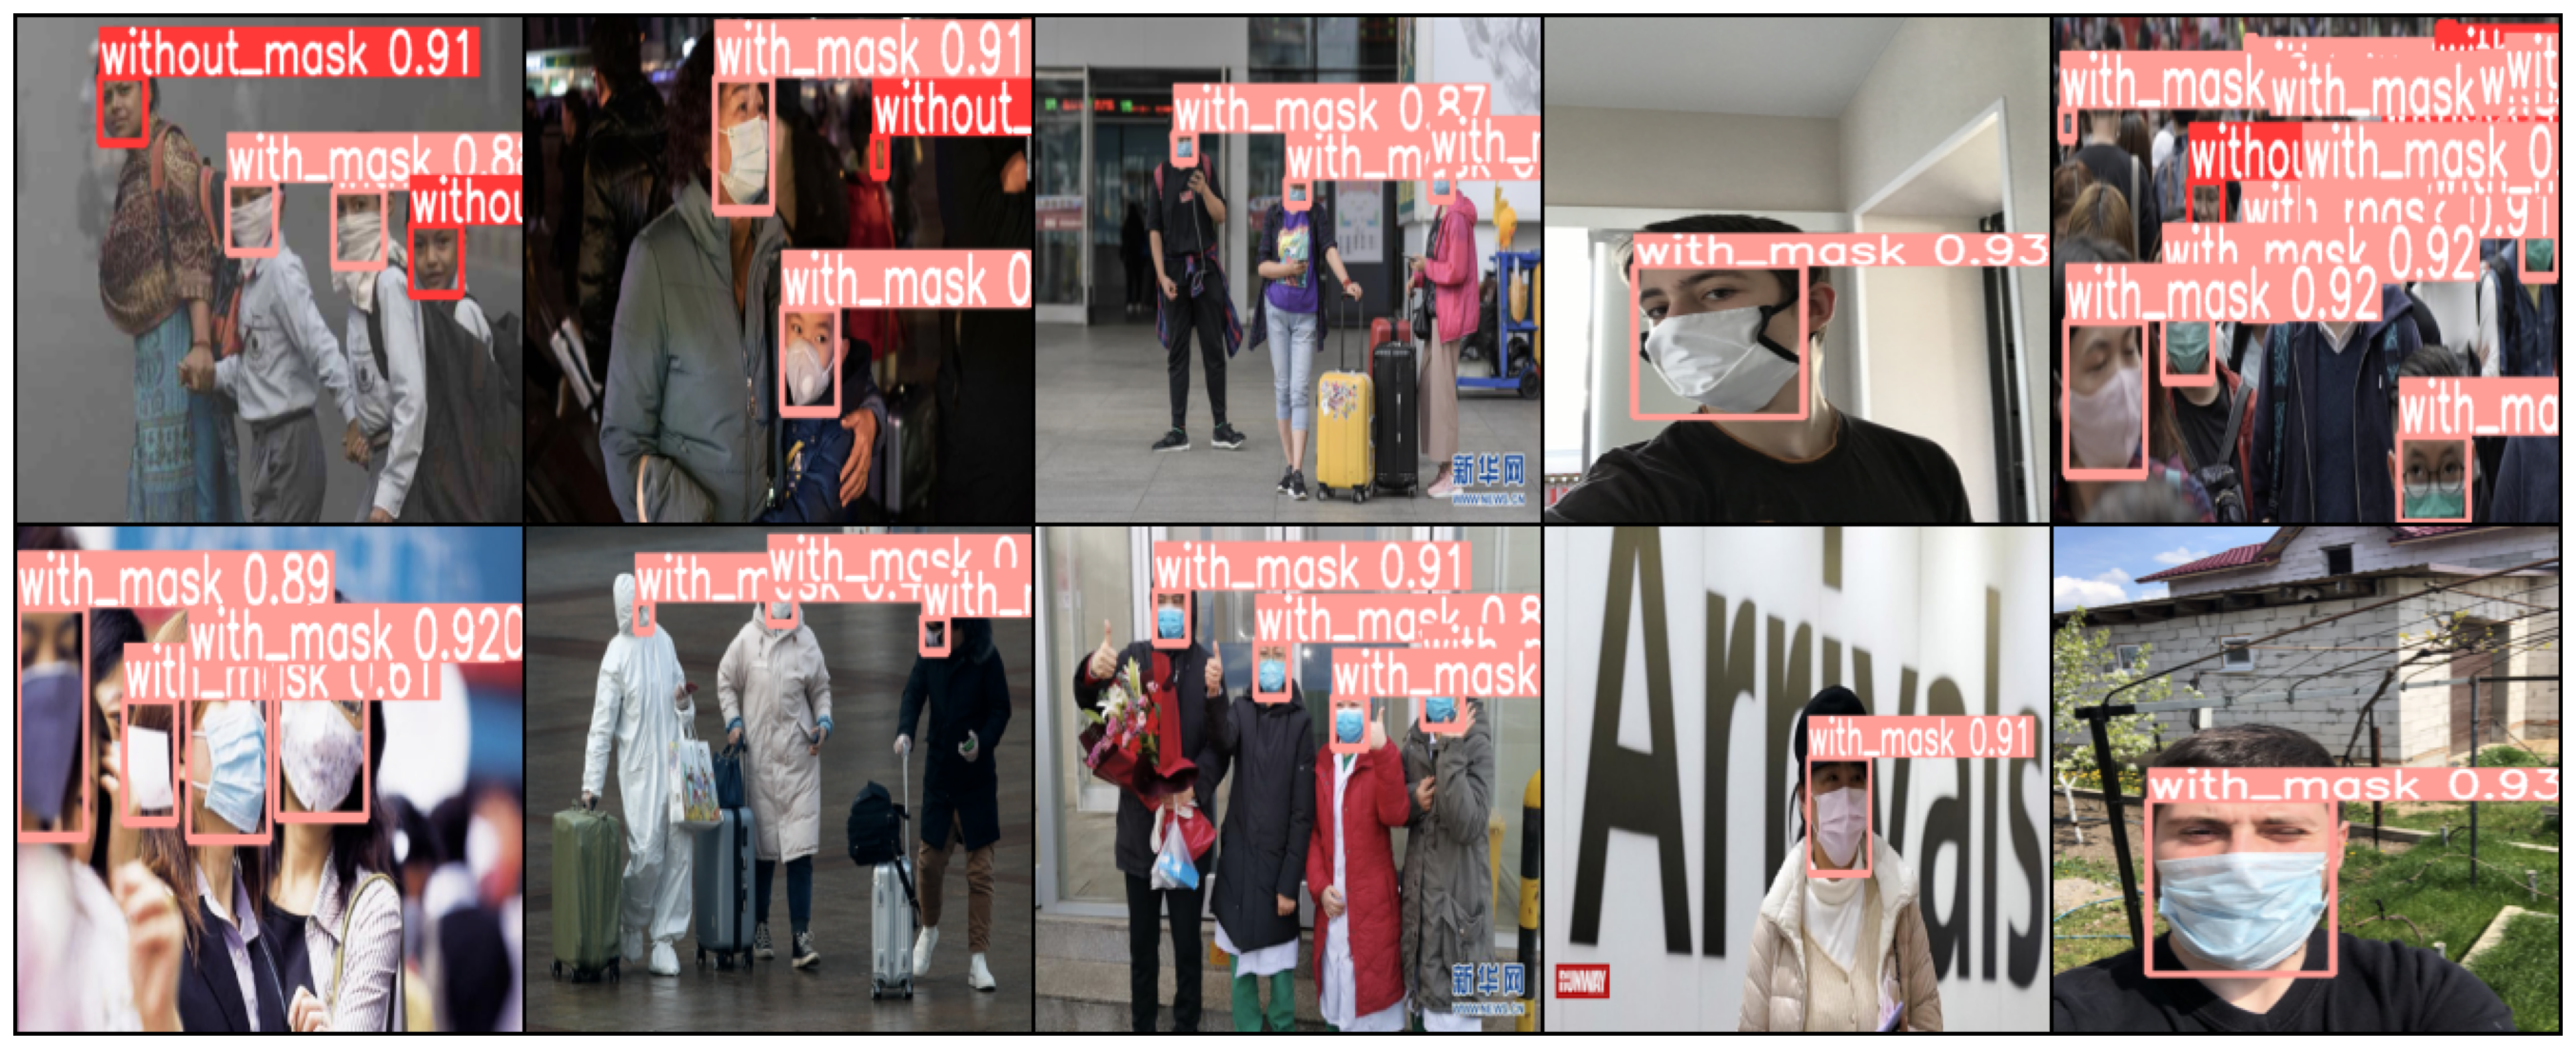

In [61]:
img_paths = list(Path("runs/detect/exp").glob("*.png"))[:10]
show_grid(img_paths)

To be honest with you. I am really blown away with the results!

## Summary

You now know how to create a custom dataset and fine-tune one of the YOLO v5 models on your own. Nice!

- [Read the tutorial](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1e4zvS6LyhOAayEDh3bz8MXFTJcVFSvZX?usp=sharing)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

Here's what you've learned:

- Install required libraries
- Build a custom dataset in YOLO/darknet format
- Learn about YOLO model family history
- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions

How well does your model do on your dataset? Let me know in the comments below.

In the next part, you'll learn how to deploy your model a mobile device.

## References

- [Clothing Item Detection for E-Commerce dataset](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce)
- [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)
- [YOLOv5 Train on Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
- [NVIDIA Apex on GitHub](https://github.com/NVIDIA/apex)
- [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/pdf/2004.10934.pdf)